# AI Challenge 2025. RL для модели Изинга

Данный блокнот является решением задачи `RL для модели Изинга` от компании `Росатом` командой `f0rtYtwO` в рамках консурса `AI Challenge 2025`.

## Формулировка задачи

В рамках задачи необходимо разработать RL-агента, способного путем последовательного изменения зарядов вершин в графе из задачи Изинга, минимизировать суммарную энергию системы.

Учитывая ограничения, формально задача формулируется следующим образом:
- Дан граф на 50 вершинах
- Каждая вершина графа имеет заряд ($s_i \in \{-1, +1\}$)
- Каждое ребро графа имеет заряд ($J_{ij} \in \{-1, +1\}$)
- Суммарная энергия системы определяется как:

$$
E(s) = - \sum_{(i,j) \in E} J_{ij} \cdot s_i \cdot s_j
$$

- Агент должен пошагово менять заряды вершин на противоположный, стремясь минимизировать суммарную энергию конфигурации. При этом политика агента должна зависеть от опыта взаимодействия со средой, а не задаваться заранее

## Формализация условий

Переведем задачу на язык Reinforcement Learning.

- **Состояние (state)**  
  Конфигурация графа в текущий момент времени, определяемая вектором зарядов вершин $s = (s_1, s_2, ..., s_{50})$, где $s_i \in \{-1, +1\}$ и матрицей смежности:

  $$
  A = (a_{ij})_{i,j=1}^{50}, \quad
  a_{ij} =
  \begin{cases}
    +1, & \text{если между вершинами $i$ и $j$ есть ребро с положительным весом}, \\
    -1, & \text{если между вершинами $i$ и $j$ есть ребро с отрицательным весом}, \\
    0,  & \text{если вершины $i$ и $j$ не соединены}.
  \end{cases}
  $$

  При этом для использования в нейронной сети, граф может быть закодирован иным способом, о чем речь пойдет дальше.  

  Всего состояний: $3 ^ {1225} · 2 ^ {50} ≈ 10 ^ {600}$.

- **Действие (action)**  
  Выбор вершины ($i$) и инверсия её спина: $$s_i \leftarrow -s_i$$

  Всего действий: $50$.

- **Награда (reward)**  
  Изменение энергии системы после совершения действия:

  $$
  r = E(s_{\text{до}}) - E(s_{\text{после}}) = (-E(s_{\text{после}})) - (-E(s_{\text{до}}))
  $$
  
  Таким образом, агент получает положительное вознаграждение, если действие уменьшает энергию системы.

- **Политика (policy)**  
  Функция, определяющая вероятность выбора действия ($a$) в состоянии ($s$):  
  
  $$
  \pi_\theta(a \mid s),
  $$

  где $\theta$ — параметры политики (нейронной сети).  

- **Эпизод (episode)**  
  Последовательность действий, начинающаяся с произвольной инициализации спинов и завершающаяся по достижении фиксированного числа шагов ($t$).

Отметим, также, что функция переходов детерменирована и нестохастична: состояние $s_{i + 1}$ однозачно и известным способом определяется по $s_{i}$ и $a$.


## Идея решения

Для решения были рассмотрены два принципиально разных подхода, существующих в RL: `Deep Q Network` и `Policy Gradient`. О плюсах и минусах каждого речь пойдет ниже, пока заметим: у обоих алгоритмов есть одна важная особенность. Необходимо придумать, как кодировать текущее представление графа перед подачей его в нейронную сеть (`Q-net` или `Policy-net` соответственно).

Каждую вершину в графе можно описать набором параметров (текущий заряд, количество соседей и т.д.), однако конкатенировать описание нескольких вершин перед подачей в нейронную сеть не вполне корректно: модели, основанные на MLP-сетях в таком случае могут "переобучиться" под порядок вершин в графе. Действительно, если **поменять номера вершин**, граф не изменится, потому не должен поменяться и вердикт нейронной сети, что, конечно, не будет соответствовать действительности: если "перемешать" список перед подачей в нейросеть, **полносвязный слой не сможет это корректно обработать**.

Поэтому было принято решение разработать архитектуру, в рамках которой на вход принимается информация **об одной вершине**, а на выход - единственное число, логит. После инференса сети на каждой из 50 вершин независимо (shared weights), к полученным логитам применяется `softmax`, откуда и получается распределение, из которого решение (action) можно сэмплировать.

Ниже на рисунке представлена схема, отражающая процесс, описанный выше.

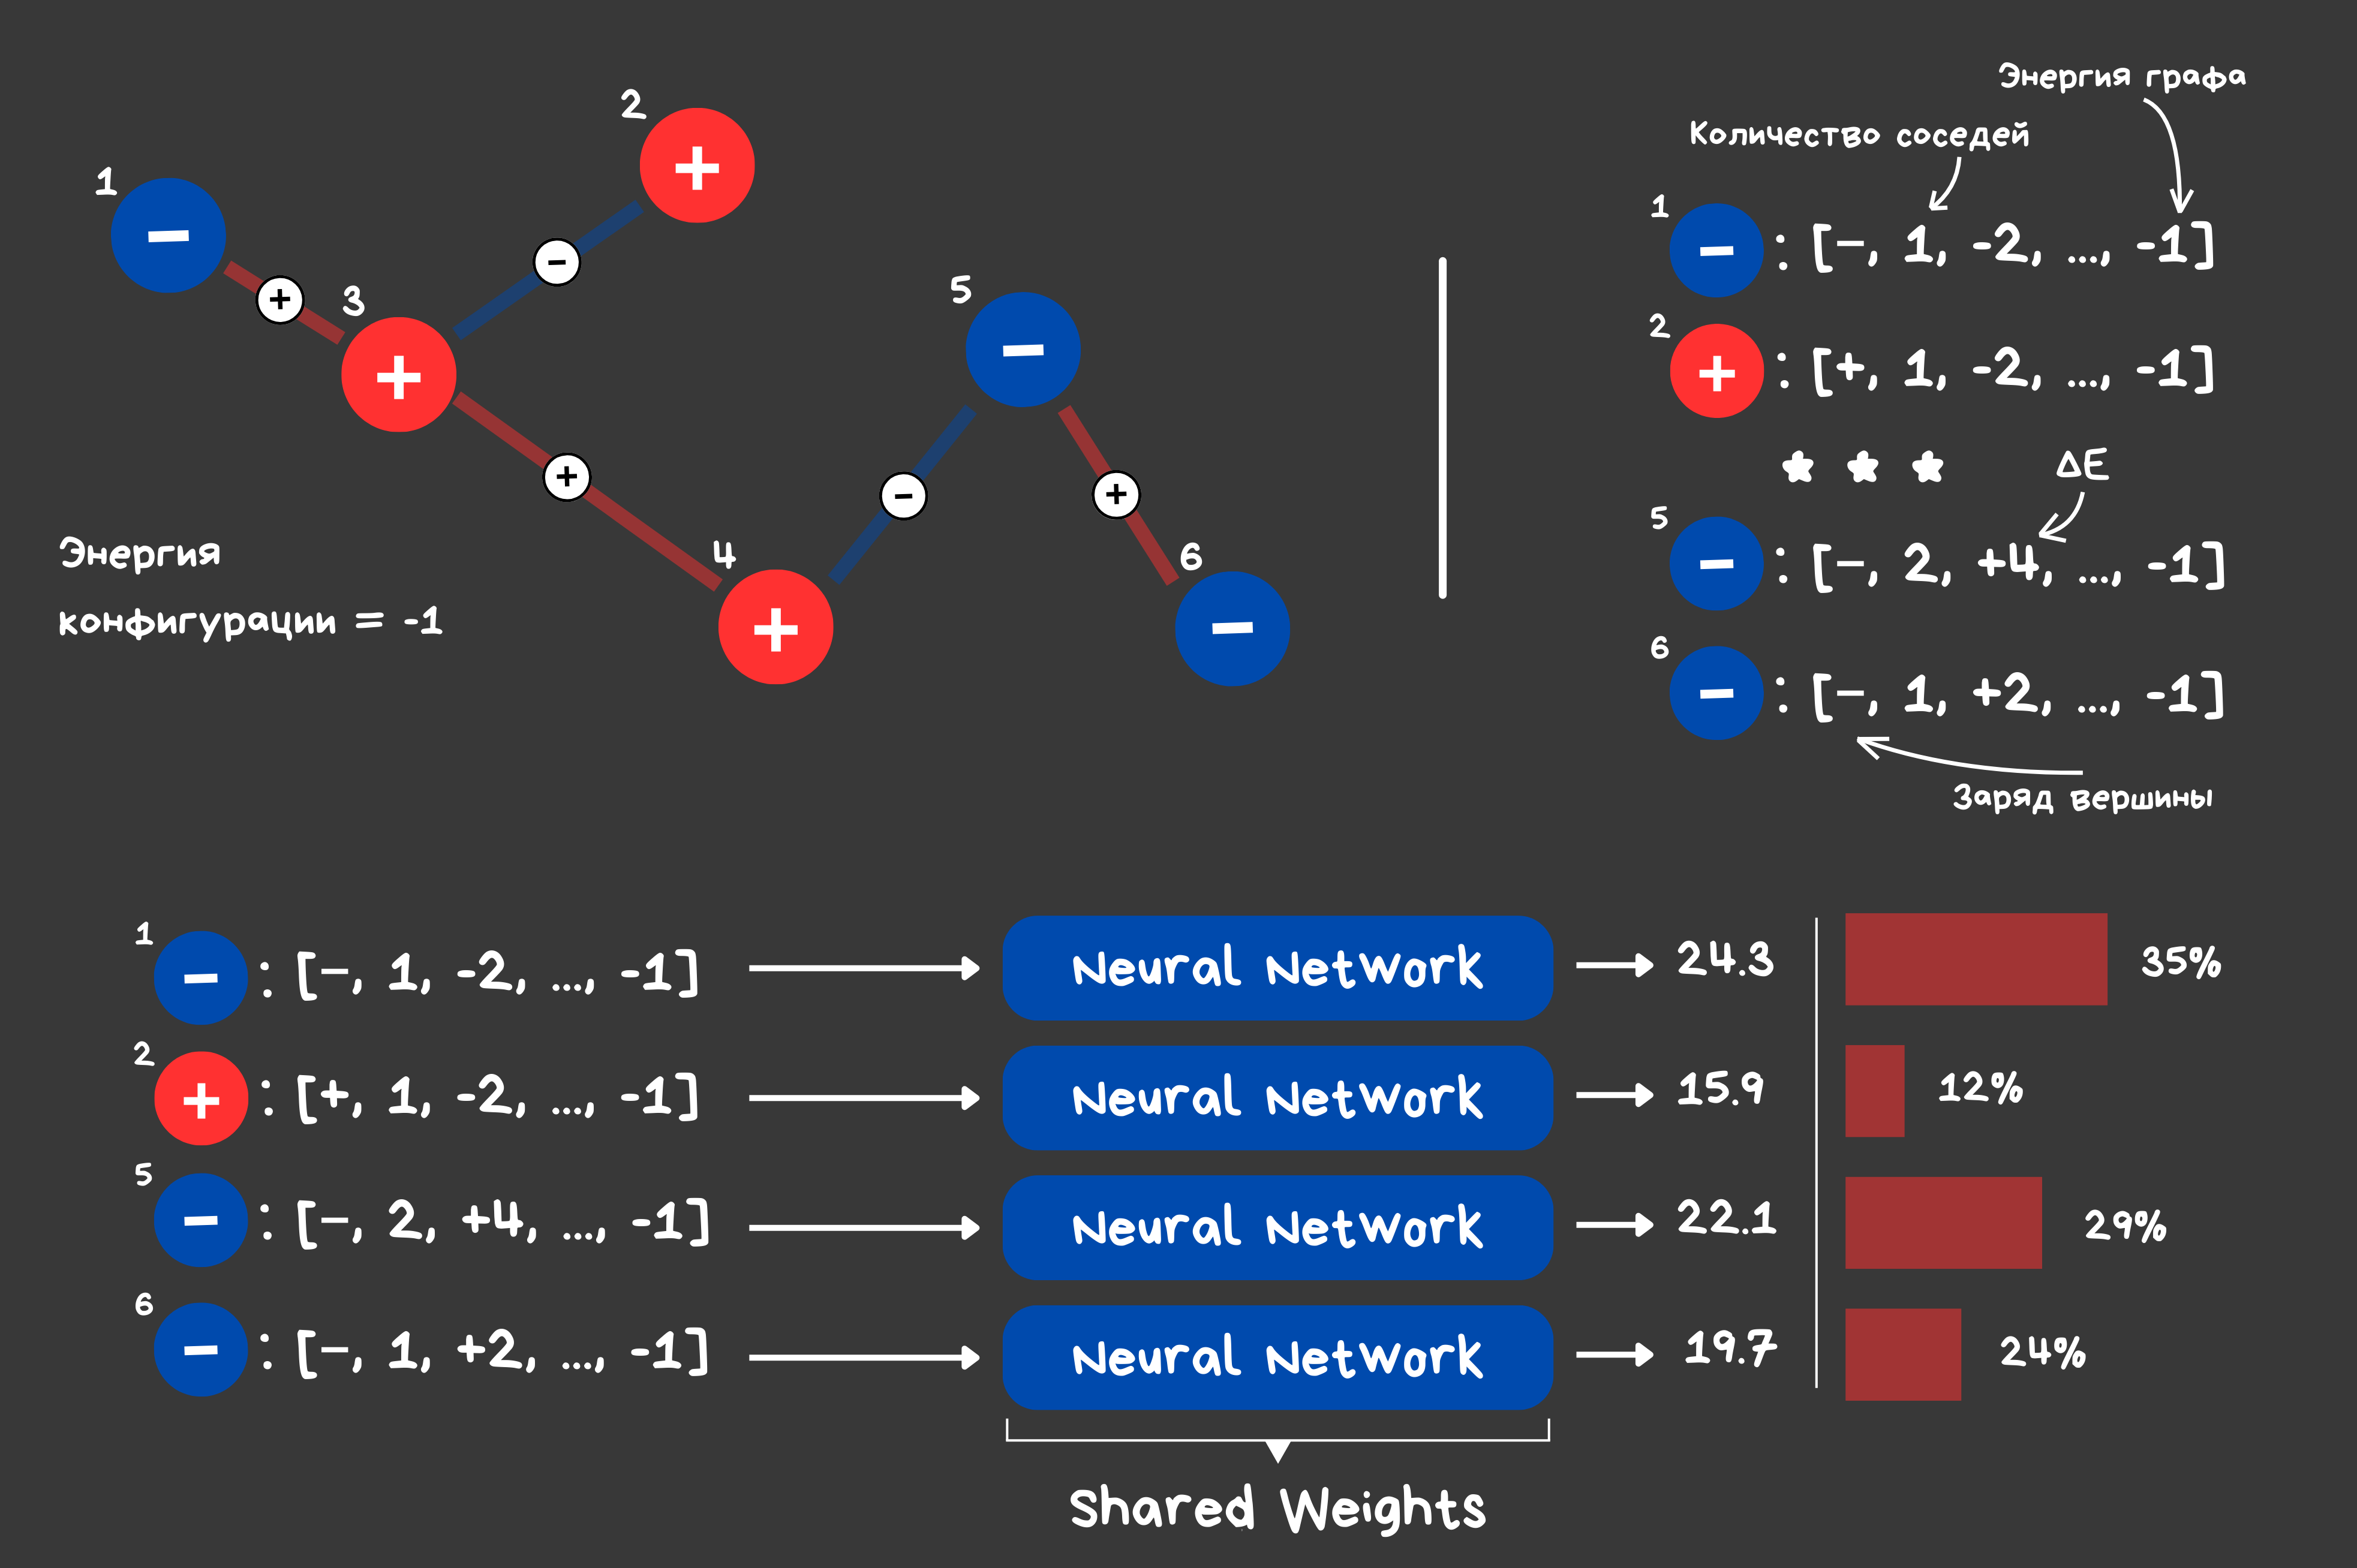

#### Полный список характеристик, которыми кодируется каждая вершина графа


- **Локальное поле спина (local_field)**  
  Поле, действующее на вершину $i$ со стороны её соседей:

  $$
  h_i = \sum_{j} J_{ij} s_j
  $$

  где $J_{ij} \in \{-1, 0, +1\}$ — элемент матрицы смежности, $s_j \in \{-1, +1\}$.

- **Локальная энергия (local_energy)**  
  Вклад вершины $i$ в общую энергию системы:  

  $$
  E_i = - s_i \cdot h_i = - s_i \sum_j J_{ij} s_j
  $$

- **Изменение энергии при флиппе спина (delta_E)**  
  Изменение энергии конфигурации при инверсии заряда $s_i$:  
  
  $$
  \Delta E_i = 2 s_i \cdot h_i
  $$

- **Степень вершины (degree)**  
  Количество соседей вершины $i$:  
  
  $$
  \deg(i) = \sum_j \mathbb{1}[J_{ij} \neq 0]
  $$

- **Количество положительно-заряженных ребер (pos_edges_from)**  
  Число исходящих ребер с положительным зарядом:  
  
  $$
  \text{pos edges from}(i) = \sum_j \mathbb{1}[J_{ij} = +1]
  $$

- **Количество отрицательно-заряженных ребер (neg_edges_from)**  
  Число исходящих ребер с отрицательным весом:  
  
  $$
  \text{neg edges from}(i) = \sum_j \mathbb{1}[J_{ij} = -1]
  $$

- **Количество положительных соседей (pos_neighbors)**  
  Число соседей с совпадающим зарядами при положительно-заряженных ребрах:  

  $$
  \text{pos neighbors}(i) = \sum_{j: J_{ij} = +1} \mathbb{1}[s_j = s_i]
  $$

- **Количество отрицательных соседей (neg_neighbors)**  
  Число соседей с совпадающим зарядами при отрицательно-заряженных ребрах:  
  
  $$
  \text{neg neighbors}(i) = \sum_{j: J_{ij} = -1} \mathbb{1}[s_j = s_i]
  $$

- **Совпадающие соседи (aligned)**  
  Количество соседей, чьи заряды совпадают с зарядом вершины $i$:  
  
  $$
  \text{aligned}(i) = \sum_{j: J_{ij} \neq 0} \mathbb{1}[s_j = s_i]
  $$

- **Несовпадающие соседи (misaligned)**  
  Количество соседей, чьи заряды противоположны заряду вершины $i$:

  $$
  \text{misaligned}(i) = \sum_{j: J_{ij} \neq 0} \mathbb{1}[s_j \neq s_i]
  $$

#### Глобальные характеристики, описывающие граф в целом (продублированы в представление каждой вершины)

- **Полная энергия системы (total_energy)**  
  Энергия всей конфигурации спинов:

  $$
  E(s) = - \sum_{(i,j) \in E} J_{ij} s_i s_j
  $$

- **Общее количество ребер (num_edges)**  
  Число ребер в графе:  

  $$
  |E| = \sum_{i < j} \mathbb{1}[J_{ij} \neq 0]
  $$

- **Нормированная энергия (norm_energy)**  
  Полная энергия, нормированная относительно количества ребер:  
  
  $$
  E_{\text{norm}} = \frac{E(s)}{|E|}
  $$

- **Количество положительно-заряженных ребер (total_pos_edges)**  
  Число ребер с весом $+1$:
  
  $$
  \text{total pos edges} = \sum_{i < j} \mathbb{1}[J_{ij} = +1]
  $$

- **Количество отрицательно-заряженных ребер (total_neg_edges)**  
  Число ребер с весом $-1$:  
  
  $$
  \text{total neg edges} = \sum_{i < j} \mathbb{1}[J_{ij} = -1]
  $$

- **Оставшееся время (time_left)**  
  Доля оставшихся шагов до завершения эпизода:  
  
  $$
  \text{time left} = 1 - \frac{t}{T_{\max}}
  $$

  где $t$ — текущий номер шага, $T_{\max}$ — максимальное число шагов в эпизоде.

## Выбор подхода

`Policy Gradient` алгоритмы в данном случае лучше подходят для решения, чем `Q-learning`: среда детерменирована и лишена стохастики, поэтому агенту нет нужды аппроксимировать Q-функцию для случайных переходов. Вместо этого можно напрямую оптимизировать вероятность выбора хороших действий.

Дополнительным условием выступает природа задачи – в модели Изинга зачастую сложно определить единственно-верное решение, их может быть несколько. Эта задача классически и достаточно успешно решалась (например, [Basit Iqbal, Kingshuk Sarkar, 2024](https://arxiv.org/html/2411.06819v1)) эвристическими подходами, потому кажется странным "заставлять" модель выбирать строго одно действие в каждом состоянии (а именно это предпологается при обучении `DQN`). Логичнее, наоборот, разрешать модели выдавать любое распределение и сэмплировать из него, увеличавая вероятности всех действий, приводящих к минимизации энергии. Именно это и происходит при обучении `Policy Gradient` алгоритмов.

Эта идея также подтверждается научными работами, где `Policy Gradient` алгоритмы оказываются лучше `DQN`: [Yicheng Lu, Xiao-Yang Liu, 2023](https://ml4physicalsciences.github.io/2023/files/NeurIPS_ML4PS_2023_248.pdf)

## Код решения

### Импорты и настройки

In [ ]:
import os
import gdown
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

In [ ]:
def seed_everything(seed: int = 42):
    """
    Функция необходима для детерменированности вычислений: так
    гарантируется получение результата из лидерборда.
    """

    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.use_deterministic_algorithms(True)

In [ ]:
seed_everything(4242)

In [ ]:
# загрузка файла с матрицами для формирования сабмита
url = "https://drive.google.com/uc?export=download&id=182XYKGxCjfJB7_HK4ljaxFXrt339bTjJ"

output_gdown = "test_matrices.npy"
gdown.download(url, output_gdown, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=182XYKGxCjfJB7_HK4ljaxFXrt339bTjJ
To: /content/test_matrices.npy
100%|██████████| 4.00M/4.00M [00:00<00:00, 52.4MB/s]


'test_matrices.npy'

❗ Обратите внимание: файл с матрицами скачан, но не сохранен в массив. Так как файл содержит графы для теста, он не может быть использован во время обучения, а потому первое использование файла будет в блоке [инфененс модели](https://colab.research.google.com/drive/1BaRzgqwnc5RtuaAdnTrjzmwlUdBtiDMa#scrollTo=x_2HwENsbfUp&line=1&uniqifier=1).

### Генерация графов

Для обучения необходимы графы, отличные от графов из тестовой выборки, но приближенные к условиям, в которых модель будет использоваться.

Для этого реализуем функцию для генерации графов на 50 вершинах с фиксированным диапозоном количества ребер и фиксированной максимальной разницей между ребрами, заряженными положительно и отрицательно.

In [ ]:
NUM_VERTICES = 50

In [ ]:
print("Количество ребер в полном графе с 50 вершинами:",
      NUM_VERTICES * (NUM_VERTICES - 1) // 2)

Количество ребер в полном графе с 50 вершинами: 1225


In [ ]:
MIN_CNT_EDGES = int(1225 * 0.15) # небольшой запас, чтобы избежать разреженных
MAX_CNT_EDGES = int(1225 * 0.85) # или почти полных графов

MEAN_CNT_EDGES = (MIN_CNT_EDGES + MAX_CNT_EDGES) // 2
STD_CNT_EDGES = (MEAN_CNT_EDGES - MIN_CNT_EDGES) // 3

MAX_DIFF = int(MEAN_CNT_EDGES * 0.1)

Количество ребер в графах тестовой выборки будет распределено нормально. Воспользуемся правилом трех сигм и определим стандартное отклонение как мат. ожидание, деленное на $3$, чтобы обе границы (и $0$, и $1225$) почти оказались включены.

Разница между количество положительно и отрицательно заряженных ребер не будет превышать 10% от среднего количества ребер в графе.

In [ ]:
def generate_adjacency_matrix(
    n: int, mean_cnt_edges: int, std_cnt_edges: int, max_diff: int
) -> tuple[np.array, int, int, int]:
    """
    Генерация случайной матрицы смежности в соответствии с
    нормальным распределением.
    """

    triu_indices = np.triu_indices(n, k=1)
    num_possible_edges = len(triu_indices[0])

    num_edges = np.random.normal(loc=mean_cnt_edges, scale=std_cnt_edges)
    num_edges_int = int(np.clip(np.round(num_edges), MIN_CNT_EDGES, MAX_CNT_EDGES))

    diff = np.random.randint(-max_diff, max_diff + 1)

    num_pos = (num_edges_int + diff) // 2
    num_neg = num_edges_int - num_pos

    chosen_indices = np.random.choice(num_possible_edges, size=num_edges_int,
                                      replace=False)

    signs = np.array([1] * num_pos + [-1] * num_neg)
    np.random.shuffle(signs)

    A = np.zeros((n, n), dtype=int)

    i_all, j_all = triu_indices
    i_sel = i_all[chosen_indices]
    j_sel = j_all[chosen_indices]

    A[i_sel, j_sel] = signs
    A[j_sel, i_sel] = signs

    return A, num_edges_int, num_pos, num_neg

In [ ]:
%%time
train_graphs = []
train_graphs_stats = []

for _ in range(10_000):
    A, total, pos, neg = generate_adjacency_matrix(
        n=NUM_VERTICES,
        mean_cnt_edges=MEAN_CNT_EDGES,
        std_cnt_edges=STD_CNT_EDGES,
        max_diff=MAX_DIFF
    )
    train_graphs += [A]
    train_graphs_stats += [np.array([total, pos - neg])]

CPU times: user 2.91 s, sys: 182 ms, total: 3.09 s
Wall time: 3.22 s


Видно, что генерация графов происходит достаточно быстро (~5000 графов в секунду).

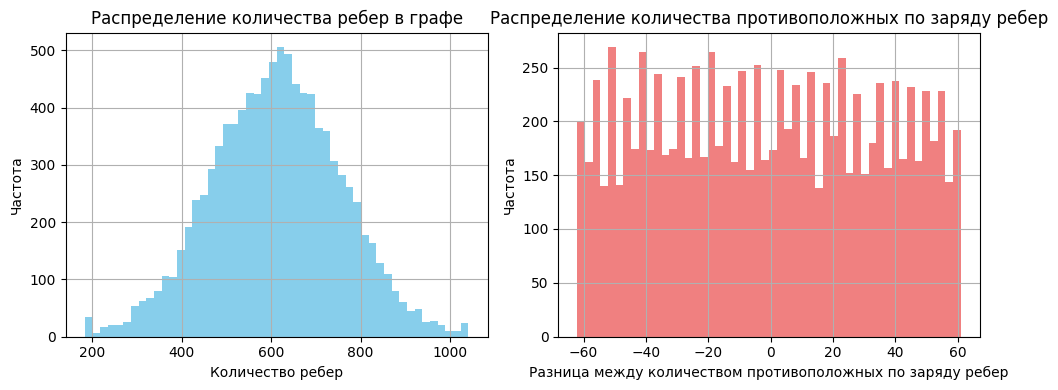

In [ ]:
train_graphs_stats = np.array(train_graphs_stats)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(train_graphs_stats[:, 0], bins=50, color='skyblue')
plt.xlabel('Количество ребер')
plt.ylabel('Частота')
plt.title('Распределение количества ребер в графе')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(train_graphs_stats[:, 1], bins=50, color='lightcoral')
plt.xlabel('Разница между количеством противоположных по заряду ребер')
plt.ylabel('Частота')
plt.title('Распределение количества противоположных по заряду ребер')
plt.grid(True)

plt.tight_layout()
plt.show()

Количество ребер должно быть распределено нормально: разреженные и близкие к полным графам встречаются реже, это логично.

В то же время разница между заряженными по-разному ребрами распределена равномерно: в пределах $10%$ от среднего количества ребер, каждое из значений может встретиться одинаково вероятно.

### Класс среды для обучения

In [ ]:
class SpinFlipEnv:
    """
    Ключевой класс для обучения модели. Описывает среду (модель Изинга).
    """

    def __init__(
        self,
        num_nodes: int,
        max_steps: int,
        adjacency_matrix: np.array=None,
        fixed_spins: bool=False
    ):
        """
        При инициализации класса фиксируется список фичей, из которых будет
        состоять репрезентация каждой вершины.
        """

        self.num_nodes = num_nodes
        self.adjacency_matrix = adjacency_matrix
        self.fixed_spins = fixed_spins
        self.num_steps = 0
        self.num_max_steps = max_steps
        self.used_mask = np.array([0] * self.num_nodes, dtype=bool)
        self.edges_list = []
        self.edges_weights = []

        self.GLOBAL_FEATURES = [
            "total_energy", "num_edges", "norm_energy",
            "total_pos_edges", "total_neg_edges", 'time_left'
        ]

        self.NODE_FEATURES = [
            "local_field", "local_energy", "delta_E",
            "degree", "pos_edges_from", "neg_edges_from",
            "pos_neighbors", "neg_neighbors",
            "aligned", "misaligned"
        ]

        self.reset()

In [ ]:
def reset(self) -> np.array:
    """
    Функция для сброса начального состояния. В зависимости от настроек, граф
    либо генерируется случайно, либо используется переданная матрица смежности.
    """

    if self.fixed_spins:
        self.spins = np.array([-1] * self.num_nodes, dtype=np.int8)
    else:
        self.reset_spins()

    if self.adjacency_matrix is not None:
        self.graph = np.array(self.adjacency_matrix)
    else:
        self.graph = np.array(generate_adjacency_matrix(
            n=NUM_VERTICES,
            mean_cnt_edges=MEAN_CNT_EDGES,
            std_cnt_edges=STD_CNT_EDGES,
            max_diff=MAX_DIFF
        )[0])

    self.used_mask = np.array([0] * self.num_nodes, dtype=bool)
    self.edges_matrix2list()
    self.num_steps = 0
    self.compute_graph_features()

    return self.get_state()

# для удобства, функции класса объявлены в отдельных ячейках
# и закреплены за классом следующим образом
SpinFlipEnv.reset = reset

In [ ]:
def compute_graph_features(self):
    """
    Функция вычисляет все фичи из репрезентации вершин после каждого шага.
    Из-за векторизованных вычислений, функция работает достаточно быстро,
    поэтому нет необходимости пересчитывать фичи из прошлых состояний.
    """

    self.features = {}
    local_field = self.graph @ self.spins
    local_energy = -self.spins * local_field
    delta_E = -2 * local_energy

    self.features["local_field"] = local_field
    self.features["local_energy"] = local_energy
    self.features["delta_E"] = delta_E
    self.features["degree"] = np.count_nonzero(self.graph, axis=1)
    self.features["pos_edges_from"] = np.sum(self.graph > 0, axis=1)
    self.features["neg_edges_from"] = np.sum(self.graph < 0, axis=1)
    self.features["pos_neighbors"] = (self.graph != 0) @ (self.spins == +1)
    self.features["neg_neighbors"] = (self.graph != 0) @ (self.spins == -1)

    sign_matrix = self.graph * np.outer(self.spins, self.spins)
    self.features["aligned"] = np.sum(sign_matrix > 0, axis=1)
    self.features["misaligned"] = np.sum(sign_matrix < 0, axis=1)

    total_energy = -0.5 * np.sum(self.graph * np.outer(self.spins, self.spins))
    self.features["total_energy"] = total_energy
    num_edges = np.count_nonzero(self.graph) // 2
    self.features["num_edges"] = num_edges
    self.features["norm_energy"] = total_energy / num_edges
    self.features["total_pos_edges"] = np.count_nonzero(self.graph > 0) // 2
    self.features["total_neg_edges"] = np.count_nonzero(self.graph < 0) // 2
    self.features['time_left'] = self.num_steps / self.num_max_steps

SpinFlipEnv.compute_graph_features = compute_graph_features

In [ ]:
def get_feature_matrix(self) -> np.array:
    """
    Функция формирует numpy-массив для дальнейшего преобразования в тензор
    и подачи в нейросеть.
    Размерность массива [NUM_NODES, NUM_LOCAL_FEATURES + NUM_GLOBAL_FEATURES]
    """

    feature_list = []
    for f in self.NODE_FEATURES:
        feature_list.append(self.features[f].reshape(self.num_nodes, 1))
    for f in self.GLOBAL_FEATURES:
        feature_list.append(np.full((self.num_nodes, 1), self.features[f]))
    return np.hstack(feature_list)

SpinFlipEnv.get_feature_matrix = get_feature_matrix

In [ ]:
def edges_matrix2list(self):
    """
    Преобразует матрицу смежности в список ребер для обеспечения
    возможности итеративного перебора (при необходимости).
    """

    self.edges_list = []
    self.edges_weights = []
    for i in range(self.num_nodes):
        for j in range(i+1, self.num_nodes):
            if self.graph[i][j] != 0:
                self.edges_list.append((i, j))
                self.edges_weights.append(self.graph[i][j])
    self.edges_list = np.array(self.edges_list)
    self.edges_weights = np.array(self.edges_weights)

SpinFlipEnv.edges_matrix2list = edges_matrix2list

In [ ]:
def step(self, action_node: int) -> tuple[np.array, int, bool, int]:
    """
    Выполняет шаг в среде. На вход принимает номер вершины и возвращает
    состояние графа после флипа этой вершины.
    """
    self.num_steps += 1
    prev_cost = self.compute_cost()

    self.flip_spin(action_node)
    self.used_mask[action_node] = 1
    new_cost = self.compute_cost()

    # так как функция compute_cost возвращает -E, считается
    # new_cost - prev_cost, а не наоборот
    reward = new_cost - prev_cost
    done = (self.num_steps >= self.num_max_steps)
    self.compute_graph_features()

    return self.get_state(), reward, done, action_node

SpinFlipEnv.step = step

In [ ]:
# ниже вспомогательные функции для корректной работы класса среды

def get_state(self):
    return self.get_feature_matrix()

def flip_spin(self, node: int):
    self.spins[node] *= -1

def compute_cost(self) -> int:
    # функция возвращает -E(graph)
    return (self.spins @ self.graph @ self.spins) / 2

def reset_spins(self):
    # при сбросе среды, если не указано иное, спины генерируются случайно
    self.spins = np.random.choice([-1, 1], size=self.num_nodes).astype(np.int8)

SpinFlipEnv.get_state = get_state
SpinFlipEnv.flip_spin = flip_spin
SpinFlipEnv.compute_cost = compute_cost
SpinFlipEnv.reset_spins = reset_spins

### Класс политики

In [ ]:
class PolicyNet(nn.Module):
    """
    Класс нейросети-политики агента REINFORCE.
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int=256,
                 num_actions: int=50):
        """
        Инициализация класса. Формирование структуры нейронной сети.
        """

        super().__init__()
        self.num_actions = num_actions

        # нейросеть принимает на вход репрезентацию вершины и возвращает логит
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )
        self.policy = nn.Linear(hidden_dim, 1)
        # для уменьшения дисперсии градиента, оценивается также value(s, a)
        self.value = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        """
        Функция для прямого прохода нейросети.
        """
        batch_size, num_nodes, _ = x.shape

        # если на вход подано несколько вершин,
        # каждая расматривается независимо (как разные элементы батча)
        x_flat = x.view(batch_size * num_nodes, -1)
        shared_out = self.shared(x_flat)
        logits = self.policy(shared_out).view(batch_size, num_nodes)
        node_values = self.value(shared_out).view(batch_size, num_nodes)

        # усреднение как способ агрегации по всем вершинам,
        # позволяет оценить качество выбора в масштабах всего графа
        state_value = node_values.mean(dim=1)

        # [BATCH_SIZE, NUM_NODES], [BATCH_SIZE]
        return logits, state_value

### Вспомогательные функции для обучения

In [ ]:
def select_action(logits: torch.tensor,
                  is_greedy: bool=False) -> tuple[torch.tensor, torch.tensor]:
    """
    Вспомогательная функция. При жадной политике возвращает наиболее
    вероятную вершину, иначе - сэмплирует из распределения.
    """
    batch_size, num_nodes = logits.shape
    dist = Categorical(logits=logits)
    if is_greedy:
        actions = logits.argmax(dim=1)
    else:
        actions = dist.sample()
    log_probs = dist.log_prob(actions)

    # [BATCH_SIZE], [BATCH_SIZE]
    return actions, log_probs

❗ Важное замечание: `REINFORCE` известен высокой дисперсией градиентов, поэтому, кроме `value`-оценки в качестве `baseline`, актуально использовать обучение с достаточно большим размером батча. Для эффективного сбора траекторий (векторизованные операции), было принято решение зафиксировать длину эпизода. Это не влияет на результат (среда детерменирована), но позволяет эффективнее обучаться, поддерживая меньшую дисперсию градиентов.

In [ ]:
def collect_trajectories(envs: list, agent: nn.Module,
                         is_greedy: bool=False) -> dict[str, torch.tensor]:
    """
    Функция для векторизованного сбора траекторий в количестве размера батча.
    """

    B = len(envs)
    buffer = {
        "states": [], "logits": [], "actions": [],
        "log_probs": [], "state_values": [], "rewards": [],
    }

    states = []
    for env in envs:
        env.reset()
        feats = env.get_state()
        states.append(torch.tensor(feats, dtype=torch.float))
    states = torch.stack(states, dim=0).to(device)

    done = False
    while not done:
        logits, state_values = agent(states)
        actions, log_probs = select_action(logits, is_greedy)

        next_states = []
        rewards = []
        for i, env in enumerate(envs):
            s, r, d, _ = env.step(actions[i].item())
            rewards.append(r)
            next_states.append(torch.tensor(s, dtype=torch.float))
            done = d

        next_states = torch.stack(next_states, dim=0).to(device)
        rewards = torch.tensor(rewards, device=device, dtype=torch.float)

        # # [T, BACTCH_SIZE, NUM_NODES, NUM_FEATURES]
        buffer["states"].append(states)
        buffer["logits"].append(logits) # [T, BACTCH_SIZE, NUM_NODES]
        buffer["actions"].append(actions) # [T, BACTCH_SIZE]
        buffer["log_probs"].append(log_probs) # [T, BACTCH_SIZE]
        buffer["state_values"].append(state_values) # [T, BACTCH_SIZE]
        buffer["rewards"].append(rewards) # [T, BACTCH_SIZE]

        states = next_states

    return {k: torch.stack(v, dim=0) for k, v in buffer.items()}

In [ ]:
def compute_returns(rewards: torch.tensor, gamma: int=0.95) -> torch.tensor:
    """
    Вспомогательная функция для подсчета returns в REINFORCE.
    """
    T, B = rewards.shape
    returns = torch.zeros_like(rewards)
    G = torch.zeros(B, device=rewards.device)
    for t in reversed(range(T)):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

In [ ]:
def reinforce_update(
    agent: nn.Module,
    buffer: dict,
    optimizer: optim.Optimizer,
    gamma: int=0.95) -> dict[str, torch.tensor]:

    """
    Функция для реализации обратного распространения ошибки, основываясь
    на собранных траекториях.
    """

    rewards = buffer["rewards"]
    state_values = buffer["state_values"]
    log_probs = buffer["log_probs"]
    logits = buffer["logits"]

    returns = compute_returns(rewards, gamma)
    advantages = returns - state_values.detach()

    policy_loss = -(log_probs * advantages).mean()
    value_loss = F.mse_loss(state_values, returns)

    # градиент прокидывается одновременно по лоссу политики и оценки value,
    # из-за того, что для получения обоих значений используются общие веса
    loss = policy_loss + value_loss

    optimizer.zero_grad()
    loss.backward()

    # дисперсия градиента может быть высока, поэтому актуально
    # не позволять быть ему больше определенного значения
    torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=1.0)
    optimizer.step()

    return {
        "loss": loss.item(),
        "policy_loss": policy_loss.item(),
        "value_loss": value_loss.item(),
        "avg_return": returns.mean().item()
    }

In [ ]:
@torch.no_grad()
def evaluate(envs: list, agent: nn.Module,
             is_greedy: bool=True) -> tuple[np.array, np.array]:
    """
    Функция для инференса агента на валидационных графах. В рамках данной
    функции, на каждом графе модель запускается лишь единожды,
    для ускорения обучения.

    По умолчанию при валидации используется жадный подход: на этом этапе
    цель - минимизировать энергию, а не дать модели возможность
    исследовать пространство событий.
    """
    B = len(envs)
    states = []
    for env in envs:
        env.reset() # перед инференсом, все среды необходимо сбросить
        s = env.get_state()
        states.append(torch.tensor(s, dtype=torch.float))
    states = torch.stack(states, dim=0).to(device)

    done = [False] * B
    while not all(done):
        logits, _ = agent(states)
        actions, _ = select_action(logits, is_greedy=is_greedy)

        next_states = []
        for i, env in enumerate(envs):
            if not done[i]:
                s, r, d, _ = env.step(actions[i].item())
                done[i] = d
                next_states.append(torch.tensor(s, dtype=torch.float))
            else:
                next_states.append(torch.tensor(env.get_state(),
                                                dtype=torch.float))

        states = torch.stack(next_states, dim=0).to(device)

    all_spins = []
    all_rewards = []
    for env in envs:
        all_spins.append(env.spins.copy())
        all_rewards.append(env.compute_cost())

    return np.array(all_spins), np.array(all_rewards)

❗ Обратите внимание: модель возвращает финальное состояние, полученное после завершения работы агента. Никакие дополнительные эвристики для выбора состояния в процессе работы **не используются**.

### Обучение модели

Обсудим параметры модели.
- **Device**. Обучение может эффективно происходить на `CPU`, из-за ограниченных возможностей для параллелизация алгоритма `REINFORCE`
- **Epoch**. Оптимальное количество эпох было подобрано эмпирически. Из графика ниже видно, что этого числа эпох хватает для сходимости на валидации.
- **Batch Size**. Размер батча выбран достаточно большим, для усреднения градиентнов. Так в том числе удается избежать резких изменений политики, свойственных `REINFROCE`.
- **Gamma**. Из-за достаточно длинных эпизодов, коэффициент дисконтирования выбран относительно низким для подобных задач.
- **Number of Steps Per Episode**. Количество шагов выбрано сообразно количеству вершин: если бы оно было меньше, оптимальная конфигурация могла бы быть теоретически недостижима.

In [ ]:
device = 'cpu'
epochs = 40
batch_size = 100
gamma = 0.95
lr = 3e-4
num_steps_per_episode = 50

In [ ]:
# инициализация случайных графов для обучения
envs = [SpinFlipEnv(num_nodes=NUM_VERTICES, max_steps=num_steps_per_episode)
        for _ in range(batch_size)]

agent = PolicyNet(input_dim=16, hidden_dim=256).to(device)
optimizer = optim.AdamW(agent.parameters(), lr=lr, weight_decay=1e-5)

# у валидационных графов фиксируем начальное состояние (спины),
# чтобы объективно мочь оценить прогресс
val_envs = [SpinFlipEnv(num_nodes=NUM_VERTICES,
                        fixed_spins=True,
                        max_steps=num_steps_per_episode)

        for _ in range(batch_size)]

all_results = []
best_model_score = float("-inf")
best_model_path = "best_model.pt"

❗ Обратите внимание: тестовые графы все еще не были загружены. Для валидации используются случайно-сгенерированные графы, поэтому корректно сохранять модель с лучшим результатом на валидации, утечки теста при этом не происходит.

Для ускорения процесса, модель с обученными весами можно найти по [ссылке](https://drive.google.com/uc?export=download&id=1K985aNyzr4qUDwn14NBNTBdJeiC-G5Ac). При этом при запуске следующей ячейки будет сохранена модель с точно такими же весами.

In [ ]:
print("[Начало обучения]")
val_scores = []
for epoch in range(epochs):
    buffer = collect_trajectories(envs, agent, is_greedy=False)
    metrics = reinforce_update(agent, buffer, optimizer, gamma)

    # валидация
    spins, rewards = evaluate(val_envs, agent, is_greedy=True)
    avg_score = np.mean(rewards)
    val_scores += [avg_score]

    print(f"""[VAL @ epoch {epoch}] Loss: {
        metrics['loss']:.3f}, Val Score: {avg_score:.3f}""")

    all_results.append([epoch, avg_score, metrics['loss']])

    if avg_score > best_model_score:
        best_model_score = avg_score
        torch.save(agent.state_dict(), best_model_path)
        print(f"Новая модель сохранена со счетом: {avg_score:.3f}")

print("[Обучение завершего]")


[Начало обучения]
[VAL @ epoch 0] Loss: 368.708, Val Score: 16.740
Новая модель сохранена со счетом: 16.740
[VAL @ epoch 1] Loss: 416.706, Val Score: 56.330
Новая модель сохранена со счетом: 56.330
[VAL @ epoch 2] Loss: 372.292, Val Score: 34.070
[VAL @ epoch 3] Loss: 417.818, Val Score: 53.270
[VAL @ epoch 4] Loss: 443.533, Val Score: 69.490
Новая модель сохранена со счетом: 69.490
[VAL @ epoch 5] Loss: 415.656, Val Score: 90.920
Новая модель сохранена со счетом: 90.920
[VAL @ epoch 6] Loss: 410.194, Val Score: 106.290
Новая модель сохранена со счетом: 106.290
[VAL @ epoch 7] Loss: 414.031, Val Score: 110.640
Новая модель сохранена со счетом: 110.640
[VAL @ epoch 8] Loss: 454.567, Val Score: 115.520
Новая модель сохранена со счетом: 115.520
[VAL @ epoch 9] Loss: 417.139, Val Score: 127.100
Новая модель сохранена со счетом: 127.100
[VAL @ epoch 10] Loss: 446.209, Val Score: 137.490
Новая модель сохранена со счетом: 137.490
[VAL @ epoch 11] Loss: 405.511, Val Score: 140.460
Новая модель

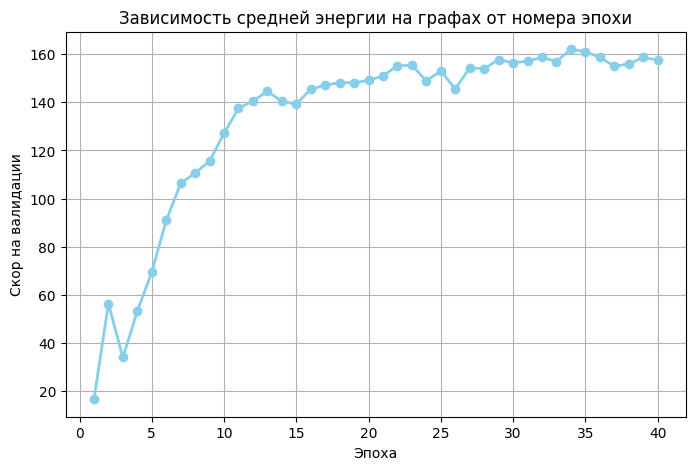

In [ ]:
epochs = np.arange(1, len(val_scores)+1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_scores, marker='o', color='skyblue', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Скор на валидации')
plt.title('Зависимость средней энергии на графах от номера эпохи')
plt.grid(True)
plt.show()

Из графика видно, что модели хватило эпох, чтобы достичь сходимости.

### Инференс модели

In [ ]:
@torch.no_grad()
def evaluate_multiple_restarts(
    graphs: np.ndarray,
    agent: nn.Module,
    num_restarts: int,
    max_steps: int,
    is_greedy: bool=False
) -> tuple[np.array, np.array]:
    """
    Функция для инференса агента на тестовых графах. Позволяет
    перезапускать агента несколько раз на одном и том же графе с разными
    начальными состояниями.
    """

    all_best_spins = []
    all_best_energies = []

    for i, graph in enumerate(tqdm(graphs, desc="Обработка графов")):
        best_energy = -float('inf')
        best_spins = None

        for restart_idx in range(num_restarts):
            # при каждом перезапуске, среда генерируется заново
            # с новым начальным состоянием спинов

            env = SpinFlipEnv(
                num_nodes=NUM_VERTICES,
                adjacency_matrix=graph,
                max_steps=max_steps
            )
            env.reset()

            state = env.get_state()
            state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            state_tensor = state_tensor.to(device)

            done = False
            while not done:
                with torch.no_grad():
                    logits, _ = agent(state_tensor)
                    action, _ = select_action(logits, is_greedy=is_greedy)

                next_state, reward, done, _ = env.step(action.item())
                state_tensor = torch.tensor(next_state,
                                            dtype=torch.float).unsqueeze(0)
                state_tensor = state_tensor.to(device)

            # используется только финальное состояние,
            # полученное после завершения работы агента
            final_energy = env.compute_cost()
            final_spins = env.spins.copy()

            if final_energy > best_energy:
                best_energy = final_energy
                best_spins = final_spins

        all_best_spins.append(best_spins)
        all_best_energies.append(best_energy)

    return np.array(all_best_spins), np.array(all_best_energies)

In [ ]:
# загрузка сохраненной модели с лучшим скором на валидации
agent.load_state_dict(torch.load(best_model_path, map_location=device))
agent.eval()

PolicyNet(
  (shared): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (policy): Linear(in_features=256, out_features=1, bias=True)
  (value): Linear(in_features=256, out_features=1, bias=True)
)

❗ Обратите внимание: это первый раз, когда загружаются графы для теста.

In [ ]:
test_graphs = np.load(output_gdown, allow_pickle=True)

Из-за большого количества перезапусков, инференс занимает достаточно много времени. Тем не менее, каждый граф обрабатывается в среднем за 20-25 секунду на `CPU`, поэтому в поставленное ограничение по времени (5 минут на один граф) агент укладывается.

In [ ]:
print("[Инференс агента на валидационных графах]")
best_spins, best_energies = evaluate_multiple_restarts(
    test_graphs,
    agent,
    num_restarts=200,
    max_steps=100,
    is_greedy=True
)

print(f"\n\nСредняя итоговая энергия по графам: {np.mean(best_energies):.3f}")

[Инференс агента на валидационных графах]


Обработка графов: 100%|██████████| 200/200 [1:22:08<00:00, 24.64s/it]



Средняя итоговая энергия по графам: 205.255


❗ Обратите внимание: средняя энергия `205.255` идентична `206.3` на лидерборде.

In [ ]:
submission_df = pd.DataFrame(best_spins)
submission_df.to_csv('submission.csv', index=False)
print("Файл сохранен.")

Файл сохранен.


Сохраненный выше файл полностью идентичен последнему загруженному в тестирующую систему.

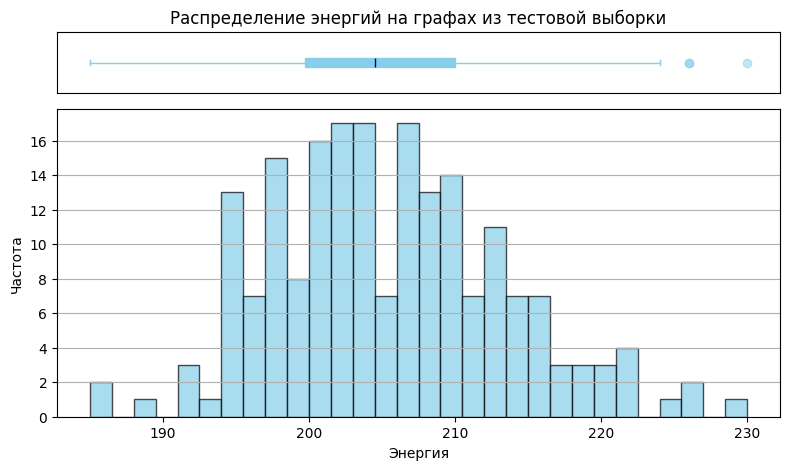

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(best_energies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_xlabel("Энергия")
ax.set_ylabel("Частота")
ax.set_title("Распределение энергий на графах из тестовой выборки")
ax.grid(True, axis='y')

ax_box = ax.inset_axes([0, 1.05, 1, 0.2])
ax_box.boxplot(best_energies, vert=False, patch_artist=True,
               boxprops=dict(facecolor='skyblue', color='skyblue'),
               whiskerprops=dict(color='skyblue'),
               capprops=dict(color='skyblue'),
               medianprops=dict(color='darkblue'),
               flierprops=dict(markerfacecolor='skyblue', markeredgecolor='skyblue', alpha=0.5))

ax_box.set_xticks([])
ax_box.set_yticks([])
ax_box.set_xlabel("")

plt.tight_layout()
plt.show()

### Визуализация работы агента

Ниже представлен код, за счет которого воспроизводится анимация пошаговых действий агента.

Генерируется случайный граф на 15-25 вершинах, в нем из нормального распределения сэмплируется количество ребер, которые произвольно получает заряды.

После этого агент запускается на полученном графе и каждое его действие отражено в анимации.

#### Код для визуализации

In [ ]:
# генерация случайного графа
num_nodes = random.randint(15, 25)
mean_edges = random.randint(40, 70)
std_edges = random.randint(8, 15)
max_diff = random.randint(3, 5)

small_graph = generate_adjacency_matrix(
    n=num_nodes,
    mean_cnt_edges=mean_edges,
    std_cnt_edges=std_edges,
    max_diff=max_diff
)[0]

In [ ]:
# создание среды
max_steps = random.randint(12, 18)
env = SpinFlipEnv(
    num_nodes=num_nodes,
    max_steps=max_steps,
    adjacency_matrix=small_graph,
    fixed_spins=False
)
env.reset()
pass

❗ Обратите внимание: после следующей ячейки на графиках ничего не отображено. Это нормально: это промежуточный шаг, устанавливающий размеры графиков.

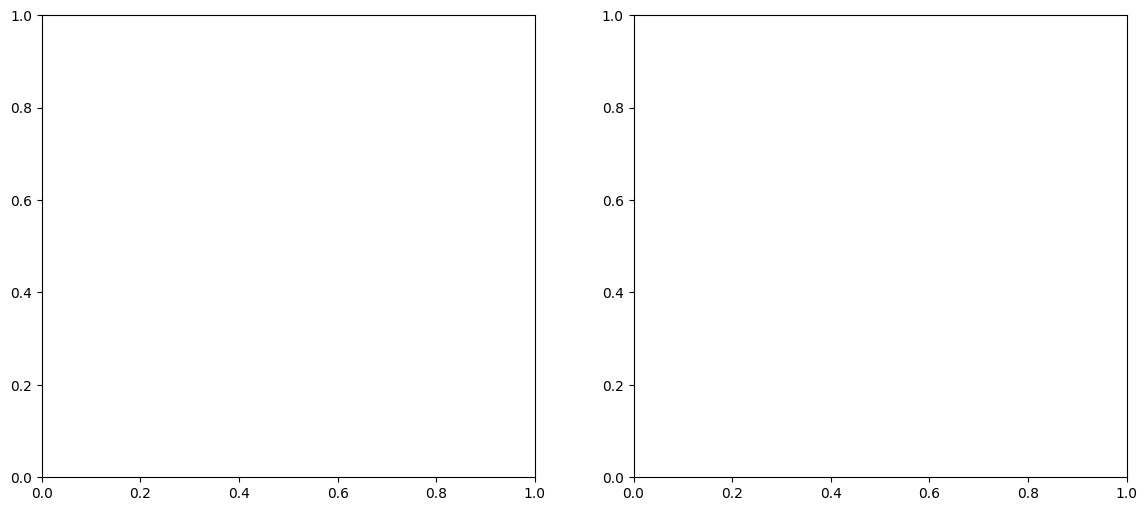

In [ ]:
# визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# layout
layout_choices = ['spring', 'circular', 'kamada_kawai']
chosen_layout = random.choice(layout_choices)

G = nx.from_numpy_array(np.abs(small_graph))

In [ ]:
# создание layout
if chosen_layout == 'spring':
    pos = nx.spring_layout(G, seed=42, k=1.2, iterations=50)
elif chosen_layout == 'circular':
    pos = nx.circular_layout(G)
else:
    pos = nx.kamada_kawai_layout(G)

In [ ]:
positive_edges = [(i, j) for i in range(num_nodes) for j in range(i+1, num_nodes) if small_graph[i, j] > 0]
negative_edges = [(i, j) for i in range(num_nodes) for j in range(i+1, num_nodes) if small_graph[i, j] < 0]

In [ ]:
def get_colors(spins: np.array) -> list[str]:
    return ['skyblue' if spin == 1 else 'lightcoral' for spin in spins]

In [ ]:
# визуализация графа
colors = get_colors(env.spins)
nodes = nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=colors,
                               node_size=500, alpha=0.9)
nx.draw_networkx_labels(G, pos, ax=ax1, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=positive_edges, ax=ax1,
                      edge_color='skyblue', width=2.0, alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=negative_edges, ax=ax1,
                      edge_color='lightcoral', width=2.0, alpha=0.8)

In [ ]:
# график энергии
energy_line, = ax2.plot([], [], color='skyblue', linewidth=3, marker='o',
                        markersize=6, markevery=[-1])
current_point = ax2.scatter([], [], c='lightcoral', s=100, zorder=5)
ax2.set_xlim(0, max_steps)
ax2.set_ylim(-100, 100)
ax2.set_xlabel('Шаг', fontsize=12)
ax2.set_ylabel('Результат (-Энергия)', fontsize=12)
ax2.set_title('Изменение энергии системы', fontsize=14)
ax2.grid(True, alpha=0.3)

In [ ]:
# отображение линии начальной энергии
initial_energy = env.compute_cost()
initial_energy_line = ax2.axhline(
    y=initial_energy,
    color='lightcoral',
    linestyle='--',
    alpha=0.7,
    label=f'Начальная: {initial_energy:.2f}'
)

In [ ]:
# отображение текстовой информации
info_text = ax2.text(
    0.7, 0.12, '',
    transform=ax2.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
)

In [ ]:
# информация о графе
ax1.set_title(f'Граф ({num_nodes} вершин, {len(positive_edges)} +ребер, {len(negative_edges)} -ребер)\n'
             f'Начальная энергия: {env.compute_cost():.2f}', fontsize=12)

Text(0.5, 1.0, 'Граф (22 вершин, 93 +ребер, 90 -ребер)\nНачальная энергия: -1.00')

In [ ]:
energies = [env.compute_cost()]
actions_history = []
initial_spins = env.spins.copy()

In [ ]:
def update(step: int):
    """
    Функция для отрисовки одного шага анимации действий агента.
    """
    if step == 0:
        return ax1, ax2

    state = torch.tensor(env.get_state(),
                         dtype=torch.float).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = agent(state)
        action, _ = select_action(logits, is_greedy=True)

    _, reward, done, _ = env.step(action.item())
    current_energy = env.compute_cost()
    energies.append(current_energy)
    actions_history.append(action.item())

    ax1.clear()
    colors = get_colors(env.spins)

    # отрисовка графа
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=colors,
                           node_size=500, alpha=0.9)
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=9, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges, ax=ax1,
                          edge_color='skyblue', width=2.0, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges, ax=ax1,
                          edge_color='lightcoral', width=2.0, alpha=0.8)

    nx.draw_networkx_nodes(G, pos, nodelist=[action.item()],
                          node_color='yellow', node_size=600,
                           alpha=0.8, ax=ax1)

    ax1.set_title(f"""Шаг {step}: вершина {action.item()}\n
    Результат (-Энергия): {current_energy:.2f} (Δ: {reward:+.2f}""",
                 fontsize=12)

    energy_line.set_data(range(len(energies)), energies)
    current_point.set_offsets([[len(energies)-1, energies[-1]]])

    if len(energies) > 1:
        current_min = min(energies)
        current_max = max(energies)
        margin = max((current_max - current_min) * 0.2, 5)
        ax2.set_ylim(current_min - margin, current_max + margin)

    ax2.set_xlim(0, max(15, len(energies) + 1))

    # аннотация последнего действия
    if len(actions_history) > 0:
        for child in ax2.get_children():
            if isinstance(child, plt.Text):
                if child.get_text().startswith('Вершина'):
                    child.remove()

        ax2.annotate(f'Вершина {actions_history[-1]}',
                    xy=(len(energies)-1, energies[-1]),
                    xytext=(10, 15), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='skyblue',
                              alpha=0.9),
                    arrowprops=dict(arrowstyle='->', color='lightcoral'))

    improvement = current_energy - initial_energy
    info_text.set_text(
        f'Начальная: {initial_energy:.2f}\n'
        f'Текущая: {current_energy:.2f}\n'
        f'Изменение: {improvement:+.2f}'
    )

    return ax1, ax2

#### Воспроизведение анимации

Слева представлен граф, при этом положительно заряженные вершины и ребра обозначены розовым (🟥), отрицательно заряженные - голубым (🟦).

Желтым (🟨) обозначена вершина, флип который агент принял решение изменить на текущем шаге.

Справа на графике представлена зависимость текущей энергии графа от номера действия.

❗ Обратите внимание: на графике ниже представлена энергия, домноженная на $-1$, соответственно агент стремиться ее максимизировать, а не минимизировать. Это сделано для того, чтобы результат было легко сопоставить с результатом в лидерборде.

In [ ]:
# воспроизведение анимации
ani = FuncAnimation(fig, update, frames=range(max_steps + 1), interval=1200,
                    repeat=False)

plt.tight_layout()
plt.close()

HTML(ani.to_jshtml())

Из визуализации видно: почти каждое действие агента приводит к уменьшению энергии конфигурации в моменте. Это объясняет, почему эвристические алгоритмы так хорошо справляются с задачей Изинга - можно не думать "наперед", а действовать почти жадно.

Кроме того, видно, что агент совершает действия до сходимости (достижение оптимальной конфигурации), после чего находит вершину, не меняющую энергию и повторяет его до конца эпизода.